<a href="https://colab.research.google.com/github/natalialopezg/Monografia-EACD/blob/master/Polyp_Segmentation_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="polyp-segmentationt"></a>
# Polyp Segmentation

<a name="objectives"></a>
## Objective
In the EDA notebook, we have explored the polyp images and masks, as well as preprocessing and split data into train, validation, and test set.

In this notebook, we will take datasets and generate batches of tensor image data with data augmentation, and then use them to train a U-Net model for polyp segmentation.

## Table of Contents
  * [Polyp Segmentation](#polyp-segmentation)
    * [Objective](#objectives)
    * [Table of Contents](#table-of-contents)
    * [Library import](#library-import)
    * [Functions definition](#functions-definition)
    * [Load data](#load-data)
      * [Extraction of data](#extraction-data)
      * [Generate data batches](#generate-data-batches)
      * [Inspect Genereated Batches](#inspect-genereated-batches)
        * [Train batches](#train-batches)
        * [Validation batches](#validation-batches)
        * [Test batch](#test-batch)
    * [U-Net Model](#u-net)
      * [Model architercture](#model-architercture)
      * [Model configuration](#model-configuration)
      * [Model training](#model-training)
      * [Model evaluation](#model-evaluation)
        * [Confusion matrix](#confusion-matrix)
        * [Precision and Recall](#precision-and-recall)
        * [IoU and Dice coefficient (F1 score)](#iou-and-dice-coefficient-(f1-score))
      * [Mask prediction](#mask-prediction)
      * [Conclusion](#conclusion)


<a name="library-import"></a>
## Library import

In [ ]:
# TensorFlow's Keras API for image data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Matplotlib and Seaborn for plotting and visualization
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

# NumPy for numerical operations
import numpy as np

# Random for generating random numbers
import random

# TensorFlow for machine learning operations
import tensorflow as tf

# Keras Model and layers for building the U-Net architecture
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, MaxPool2D, Concatenate

# Regularizers and Optimizers for the model
from keras.regularizers import l2
from keras.optimizers import Adam, Nadam

# Callbacks for model training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Scikit-learn metrics for evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Utilities for handling zip files
import zipfile
import gdown

<a name="functions-definition"></a>
## Functions definition

In [ ]:
def generate_data_batches(data_dir, batch_size, target_size, seed=None, train_augmentation=False):
    """
    Generate data batches for image segmentation tasks.

    Args:
        data_dir (str): The directory containing the dataset with subdirectories for train, validation, and test sets.
        batch_size (int): The batch size to use for the data generators.
        target_size (tuple): The target size to resize the images and masks, specified as (height, width).
        seed (int or None, optional): Random seed for reproducibility. Defaults to None.
        train_augmentation (bool, optional): Flag to enable data augmentation for the training set. Defaults to False.

    Returns:
        tuple: A tuple containing the following data generators:
            - train_images_generator (DirectoryIterator): Data generator for training set images.
            - train_masks_generator (DirectoryIterator): Data generator for training set masks.
            - valid_images_generator (DirectoryIterator): Data generator for validation set images.
            - valid_masks_generator (DirectoryIterator): Data generator for validation set masks.
            - test_images_generator (DirectoryIterator): Data generator for test set images.
            - test_masks_generator (DirectoryIterator): Data generator for test set masks.
    """

    # Rescaling factor for all sets
    rescale_factor = 1.0 / 255.0

    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Data augmentation for the training set
    if train_augmentation:
        train_data_generator = ImageDataGenerator(
            rescale=rescale_factor,
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=20,
            zoom_range=0.2,
            shear_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.7, 1.3],
            fill_mode='reflect',
        )
    else:
        train_data_generator = ImageDataGenerator(rescale=rescale_factor)

    # Data generators for validation and test sets (without augmentation)
    valid_data_generator = ImageDataGenerator(rescale=rescale_factor)
    test_data_generator = ImageDataGenerator(rescale=rescale_factor)

    # Flow data from directories and apply augmentation where applicable
    train_images_generator = train_data_generator.flow_from_directory(
        data_dir + '/train/images',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=True,
        seed=seed
    )

    train_masks_generator = train_data_generator.flow_from_directory(
        data_dir + '/train/masks',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode = 'grayscale',
        shuffle=True,
        seed=seed
    )

    valid_images_generator = valid_data_generator.flow_from_directory(
        data_dir + '/valid/images',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,
        seed=seed
    )

    valid_masks_generator = valid_data_generator.flow_from_directory(
        data_dir + '/valid/masks',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode = 'grayscale',
        shuffle=False,
        seed=seed
    )

    test_images_generator = test_data_generator.flow_from_directory(
        data_dir + '/test/images',
        target_size=target_size,
        batch_size=100, # set test batch size = full test sample size
        class_mode=None,
        shuffle=False,
        seed=seed
    )

    test_masks_generator = test_data_generator.flow_from_directory(
        data_dir + '/test/masks',
        target_size=target_size,
        batch_size=100, # set test batch size = full test sample size
        class_mode=None,
        color_mode = 'grayscale',
        shuffle=False,
        seed=seed
    )

    return (
        train_images_generator, train_masks_generator,
        valid_images_generator, valid_masks_generator,
        test_images_generator, test_masks_generator
    )

def conv_block(input, num_filters):
  """
  Create a block of two convolutional layers each followed by batch normalization and ReLU activation.

  Args:
      input (Tensor): Input tensor.
      num_filters (int): Number of filters for the convolutional layers.

  Returns:
      x (Tensor): Output tensor after applying two convolutional layers, batch normalization, and ReLU activation.
  """

  # First convolutional layer
  x = Conv2D(num_filters, 3,#kernel_initializer='he_uniform',
             kernel_regularizer=l2(1e-5),padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  # Second convolutional layer
  x = Conv2D(num_filters, 3,#kernel_initializer='he_uniform',
             kernel_regularizer=l2(1e-5),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  # Adding Dropout after the activation
  # x = Dropout(0.25)(x)
  return x

def encoder_block(input, num_filters):
  """
  Create an encoder block with a convolutional block followed by max-pooling.

  Args:
      input (Tensor): Input tensor.
      num_filters (int): Number of filters for the convolutional layers.

  Returns:
      x (Tensor): Output tensor after the convolutional block.
      p (Tensor): Output tensor after max-pooling.
  """

  # Convolutional block
  # The conv output can be used for concatenation (skip connections) with decoder
  x = conv_block(input, num_filters)

  # Max-pooling
  p = MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  """
  Create a decoder block with a transposed convolutional layer and a convolutional block.

  Args:
      input (Tensor): Input tensor.
      skip_features (Tensor): Tensor from the encoder to be concatenated with the input.
      num_filters (int): Number of filters for the convolutional layers.

  Returns:
      x (Tensor): Output tensor after the decoder block.
  """

  # Transposed convolutional layer
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, kernel_regularizer=l2(1e-5),padding="same")(input)

  # Concatenation with skip connection features
  x = Concatenate()([x, skip_features])

  # Convolutional block
  x = conv_block(x, num_filters)
  return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
  """
  Build a U-Net model for image segmentation.

  Args:
      input_shape (tuple): Shape of the input image (height, width, channels).
      n_classes (int): Number of classes for segmentation.

  Returns:
      model (Model): U-Net model.
  """
  inputs = Input(input_shape)

  # Encoder blocks
  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  # Bridge
  b1 = conv_block(p4, 1024)

  # Decoder blocks
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  # Output layer: choose activation function based on the number of classes
  if n_classes == 1:  #Binary
    activation = 'sigmoid'
  else:
    activation = 'softmax'

  outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
  print(f"Output activation: {activation}")

  model = Model(inputs, outputs, name="U-Net")
  return model

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculate the Dice coefficient for evaluating segmentation performance.

    Args:
        y_true (tensor): Ground truth binary labels.
        y_pred (tensor): Predicted binary labels.
        smooth (float, optional): Smoothing factor to avoid division by zero. Default is 1.

    Returns:
        float: Dice coefficient value.
    """
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    """
    Calculate the Dice loss based on the Dice coefficient.

    Args:
        y_true (tensor): Ground truth binary labels.
        y_pred (tensor): Predicted binary labels.

    Returns:
        float: Dice loss value.
    """
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

def iou_coefficient(y_true, y_pred, smooth=1):
    """
    Calculate the Intersection over Union (IoU) coefficient.

    Args:
        y_true (tensor): Ground truth binary labels.
        y_pred (tensor): Predicted binary labels.
        smooth (float, optional): Smoothing factor to avoid division by zero. Default is 1.

    Returns:
        float: IoU coefficient value.
    """
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def iou_loss(y_true, y_pred):
    """
    Calculate the IoU loss based on the IoU coefficient.

    Args:
        y_true (tensor): Ground truth binary labels.
        y_pred (tensor): Predicted binary labels.

    Returns:
        float: IoU loss value.
    """
    loss = 1 - iou_coefficient(y_true, y_pred)
    return loss

<a name="load-data"></a>
## Load data

<a name="extraction-data"></a>
### Extraction of data

In [ ]:
# URL of the file to download
url = 'https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM'

root_dir = '/tmp'
# root_dir = r"C:\Users\nata-\OneDrive\Documentos\UDEA\data"

# Path to save the downloaded file locally
output_path = f"{root_dir}/prepared_data.zip"

# Download the file
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM
From (redirected): https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM&confirm=t&uuid=5cb25eb8-a062-4b6e-94b5-fbca0246a765
To: /tmp/prepared_data.zip
100%|██████████| 30.8M/30.8M [00:01<00:00, 20.6MB/s]


'/tmp/prepared_data.zip'

In [ ]:
# Extract data from zip
local_zip = output_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f"{root_dir}/prepared_data")
zip_ref.close()

In order to set up the generator properly, our image data is organized the same as the following structure. Note that it's important to make sure the images and masks within the set are stored in their respected subfolders with the same name. For example, both test images and test masks are stored in their respected subfolders with the same name "test".
```
prepared_data
├── test
│   ├── images
│   │   ├── test
│   │   │   ├── 0011.jpg
│   │   │   ├── 0024.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── test
│   │   │   ├── 0011.jpg
│   │   │   ├── 0024.jpg
│   │   │   ├── ...
│   
├── train
│   ├── images
│   │   ├── train
│   │   │   ├── 0001.jpg
│   │   │   ├── 0002.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── train
│   │   │   ├── 0001.jpg
│   │   │   ├── 0002.jpg
│   │   │   ├── ...
│   
├── valid
│   ├── images
│   │   ├── valid
│   │   │   ├── 0008.jpg
│   │   │   ├── 0009.jpg
│   │   │   ├── ...
│   ├── masks
│   │   ├── valid
│   │   │   ├── 0008.jpg
│   │   │   ├── 0009.jpg
│   │   │   ├── ...


```

<a name="generate-data-batches"></a>
### Generate data batches

Prior to batch generation, the image data is rescaled to an interval from 0 to 1. This normalization ensures that the data falls within a similar interval and maintains a consistent scale, potentially improving model performance and convergence.

In addition, data augmentation techniques are employed to improve the diversity and variability of the training data. These techniques consist of applying random transformations such as random flips, rotations, zooms, shears and displacements to the images. In this way, variations of the original images are created that ultimately improve the generalization and robustness of the deep learning model by exposing it to a wider range of image variations.

In [ ]:
# Set parameters for `generate_data_batches` functon
data_dir = '/tmp/prepared_data'
batch_size = 16
seed = 123
target_size = (256, 256)

# Generate the data batches using the specified parameters
(train_images_gen, train_masks_gen,
 validation_images_gen, validation_masks_gen,
 test_images_gen, test_masks_gen) = generate_data_batches(
    data_dir,
    batch_size,
    target_size=target_size,
    seed=seed,
    train_augmentation=True
)

# Pack train generator as `(x, y)` and validation genereators as `(x_val, y_val)`
train_generator = zip(train_images_gen, train_masks_gen)
val_generator = zip(validation_images_gen, validation_masks_gen)

Found 916 images belonging to 1 classes.
Found 916 images belonging to 1 classes.
Found 185 images belonging to 1 classes.
Found 185 images belonging to 1 classes.
Found 189 images belonging to 1 classes.
Found 189 images belonging to 1 classes.


<a name="inspect-genereated-batches"></a>
### Inspect Genereated Batches

Once we set up the data generators for the training, validation, and testing sets, we can have a look at the content of the data batches.

Let's start with train data batches.

<a name="train-batches"></a>
#### Train batches

If we divide the number of available samples by the specified batch size, we will get the steps which will be passed as argument when training our segmentation model.

In [ ]:
# Get the number of samples in the train images
train_samples = train_images_gen.samples

# Get the batch size
batch_size = train_images_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print(f"Train Images\n{'--'*18}")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Images
------------------------------------
Number of samples: 916
Batch size: 16
Number of batches (train steps): 57


In [ ]:
# Get the number of samples in the train masks
train_samples = train_masks_gen.samples

# Get the batch size
batch_size = train_masks_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print(f"Train Masks\n{'--'*18}")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Masks
------------------------------------
Number of samples: 916
Batch size: 16
Number of batches (train steps): 57


Let's visualize some examples of our train batches. We will look at the first 5 images of our first 3 batches.

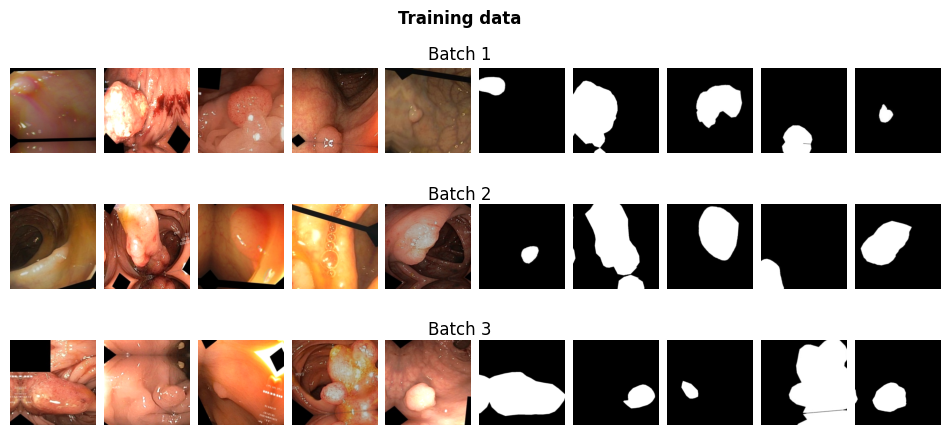

In [ ]:
# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(12, 5))

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    batch_images = train_images_gen.next()[:images_per_batch]
    batch_masks = train_masks_gen.next()[:images_per_batch]

    for j in range(images_per_batch):
        # Plot the image
        axes[i, j].imshow(batch_images[j], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(batch_masks[j], cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(top = 0.9, wspace=0.1, hspace=0.1)

fig.suptitle("Training data", size=12, fontweight = 'bold')
plt.figtext(0.5, 0.89, "Batch 1", va="center", ha="center", size=12)
plt.figtext(0.5, 0.61, "Batch 2", va="center", ha="center", size=12)
plt.figtext(0.5, 0.34, "Batch 3", va="center", ha="center", size=12)
# Show the plot
plt.show()

In [ ]:
print("Minimum train image pixel value:", batch_images[0].min())
print("Maximum train image pixel value:", batch_images[0].max())
print("Minimum train mask pixel value:", batch_masks[0].min())
print("Maximum train mask pixel value:", batch_masks[0].max())

Minimum train image pixel value: 0.0
Maximum train image pixel value: 1.0
Minimum train mask pixel value: 0.0
Maximum train mask pixel value: 1.0


We can see that in the previous notebook, the minimum and maximum pixel value of our image is (0, 255). After rescaling, the the minimum and maximum pixel value of our image is between 0 and 1.


<a name="validation-batches"></a>
#### Validation batches

For validation batches, the number of steps is smaller as compared to train batches as we have lesser samples in the validation set than in the train set.

In [ ]:
# Get the number of samples in the validation images
validation_samples = validation_images_gen.samples

# Get the batch size
batch_size = validation_images_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
validation_steps = validation_samples / batch_size

# Print the number of samples, batch size, and number of batches
print(f"Validation Images\n{'--'*18}")
print("Number of samples:", validation_samples)
print("Batch size:", batch_size)
print("Number of batches (validation steps):", round(validation_steps))

Validation Images
------------------------------------
Number of samples: 185
Batch size: 16
Number of batches (validation steps): 12


In [ ]:
# Get the number of samples in the validation masks
validation_samples = validation_masks_gen.samples

# Get the batch size
batch_size = validation_masks_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
validation_steps = validation_samples / batch_size

# Print the number of samples, batch size, and number of batches
print(f"Validation Masks\n{'--'*18}")
print("Number of validation samples:", validation_samples)
print("Batch size:", batch_size)
print("Number of validation batches (validation steps):", round(validation_steps))

Validation Masks
------------------------------------
Number of validation samples: 185
Batch size: 16
Number of validation batches (validation steps): 12


Let's visualize some examples of our validation batches. We will look at the first 5 images of our first 3 batches.

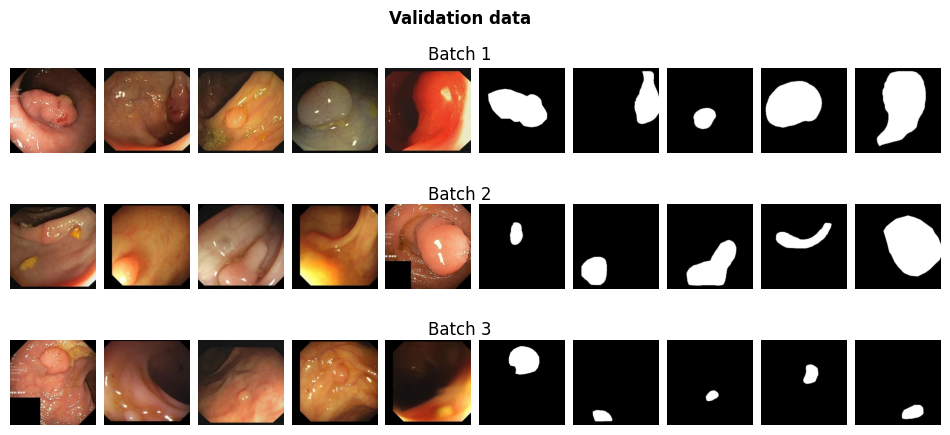

In [ ]:
# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(12, 5))

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    batch_images = validation_images_gen.next()[:images_per_batch]
    batch_masks = validation_masks_gen.next()[:images_per_batch]

    for j in range(images_per_batch):
        # Plot the image
        axes[i, j].imshow(batch_images[j], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(batch_masks[j], cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(top = 0.9, wspace=0.1, hspace=0.1)

fig.suptitle("Validation data", size=12, fontweight = 'bold')
plt.figtext(0.5, 0.89, "Batch 1", va="center", ha="center", size=12)
plt.figtext(0.5, 0.61, "Batch 2", va="center", ha="center", size=12)
plt.figtext(0.5, 0.34, "Batch 3", va="center", ha="center", size=12)
# Show the plot
plt.show()

In [ ]:
print("Minimum validation image pixel value:", batch_images[0].min())
print("Maximum validation image pixel value:", batch_images[0].max())
print("Minimum validation mask pixel value:", batch_masks[0].min())
print("Maximum validation mask pixel value:", batch_masks[0].max())

Minimum validation image pixel value: 0.0
Maximum validation image pixel value: 1.0
Minimum validation mask pixel value: 0.0
Maximum validation mask pixel value: 1.0


Same as the train batches, after rescaling, the the minimum and maximum pixel value of our image data is between 0 and 1.

<a name="test-batch"></a>
#### Test batch

For test batch, we don't need to calculate the number of steps and pass it in as argument during model training as we only use the test batch for model evaluation.

We set the test batch size to full test sample size therefore there will be just one step. We can verify the test batch size.

In [ ]:
test_images_gen.batch_size

100

Let's visualize first 15 images of our test batch.

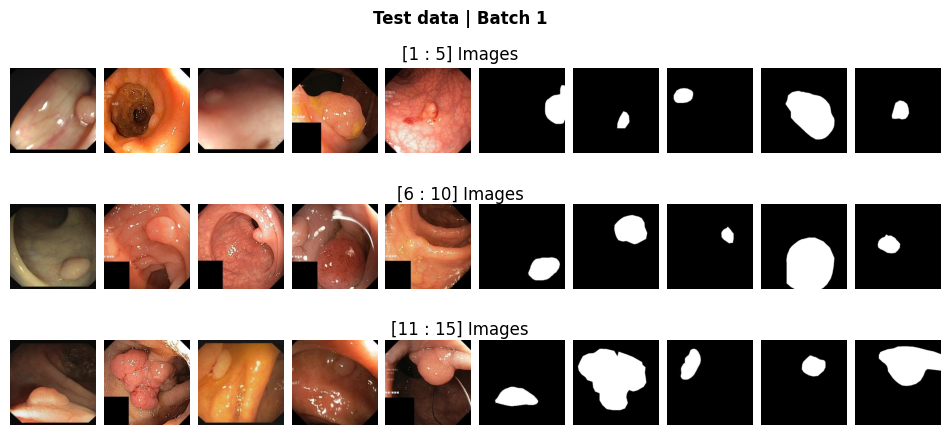

In [ ]:
# Set the number of rows and columns for the grid
num_rows = 3
num_cols = 5
total_images = num_rows * num_cols # total of 15 images to display

# Plot the images and masks in a grid
fig, axes = plt.subplots(num_rows, 2 * num_cols, figsize=(12, 5))

# Get the test batch
test_batch_images = test_images_gen.next()
test_batch_masks = test_masks_gen.next()

# Iterate over the images in the test batch and plot them in the grid
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        # Plot the image
        axes[i, j].imshow(test_batch_images[index], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + num_cols].imshow(test_batch_masks[index], cmap='gray')
        axes[i, j + num_cols].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(top = 0.9, wspace=0.1, hspace=0.1)

fig.suptitle("Test data | Batch 1", size=12, fontweight = 'bold')
plt.figtext(0.5, 0.89, "[1 : 5] Images", va="center", ha="center", size=12)
plt.figtext(0.5, 0.61, "[6 : 10] Images", va="center", ha="center", size=12)
plt.figtext(0.5, 0.34, "[11 : 15] Images", va="center", ha="center", size=12)

# Show the plot
plt.show()

In [ ]:
print("Minimum test image pixel value:", batch_images[0].min())
print("Maximum test image pixel value:", batch_images[0].max())
print("Minimum test mask pixel value:", batch_masks[0].min())
print("Maximum test mask pixel value:", batch_masks[0].max())

Minimum test image pixel value: 0.0
Maximum test image pixel value: 1.0
Minimum test mask pixel value: 0.0
Maximum test mask pixel value: 1.0


Same as the train and validation batches, after rescaling, the the minimum and maximum pixel value of our image data is between 0 and 1.

<a name="u-net"></a>
## U-Net Model

The U-Net architecture is a convolutional neural network (CNN) specifically designed for fast and accurate segmentation of biomedical images. Initially developed for tasks such as segmenting neuronal structures in electron microscopic stacks, its effectiveness and flexibility have led to its use in a wide array of image segmentation tasks beyond biomedical applications. The architecture offers several benefits:

Data Efficiency: U-Net is recognized for its data efficiency, achieving good results even with a limited amount of training data.
High Resolution: Designed to produce high-resolution output, U-Net is ideal for tasks that require detailed image analysis.
Versatility: Although originally created for biomedical image segmentation, U-Net has been successfully adapted for various other image segmentation tasks.
Many subsequent architectures have been inspired by or have built upon U-Net for a variety of segmentation and even some non-segmentation tasks.

<a name="model-architercture"></a>
### Model architercture
The U-Net architecture can be visualized as a "U" shape, which gives it its name. Here's a breakdown of its structure:

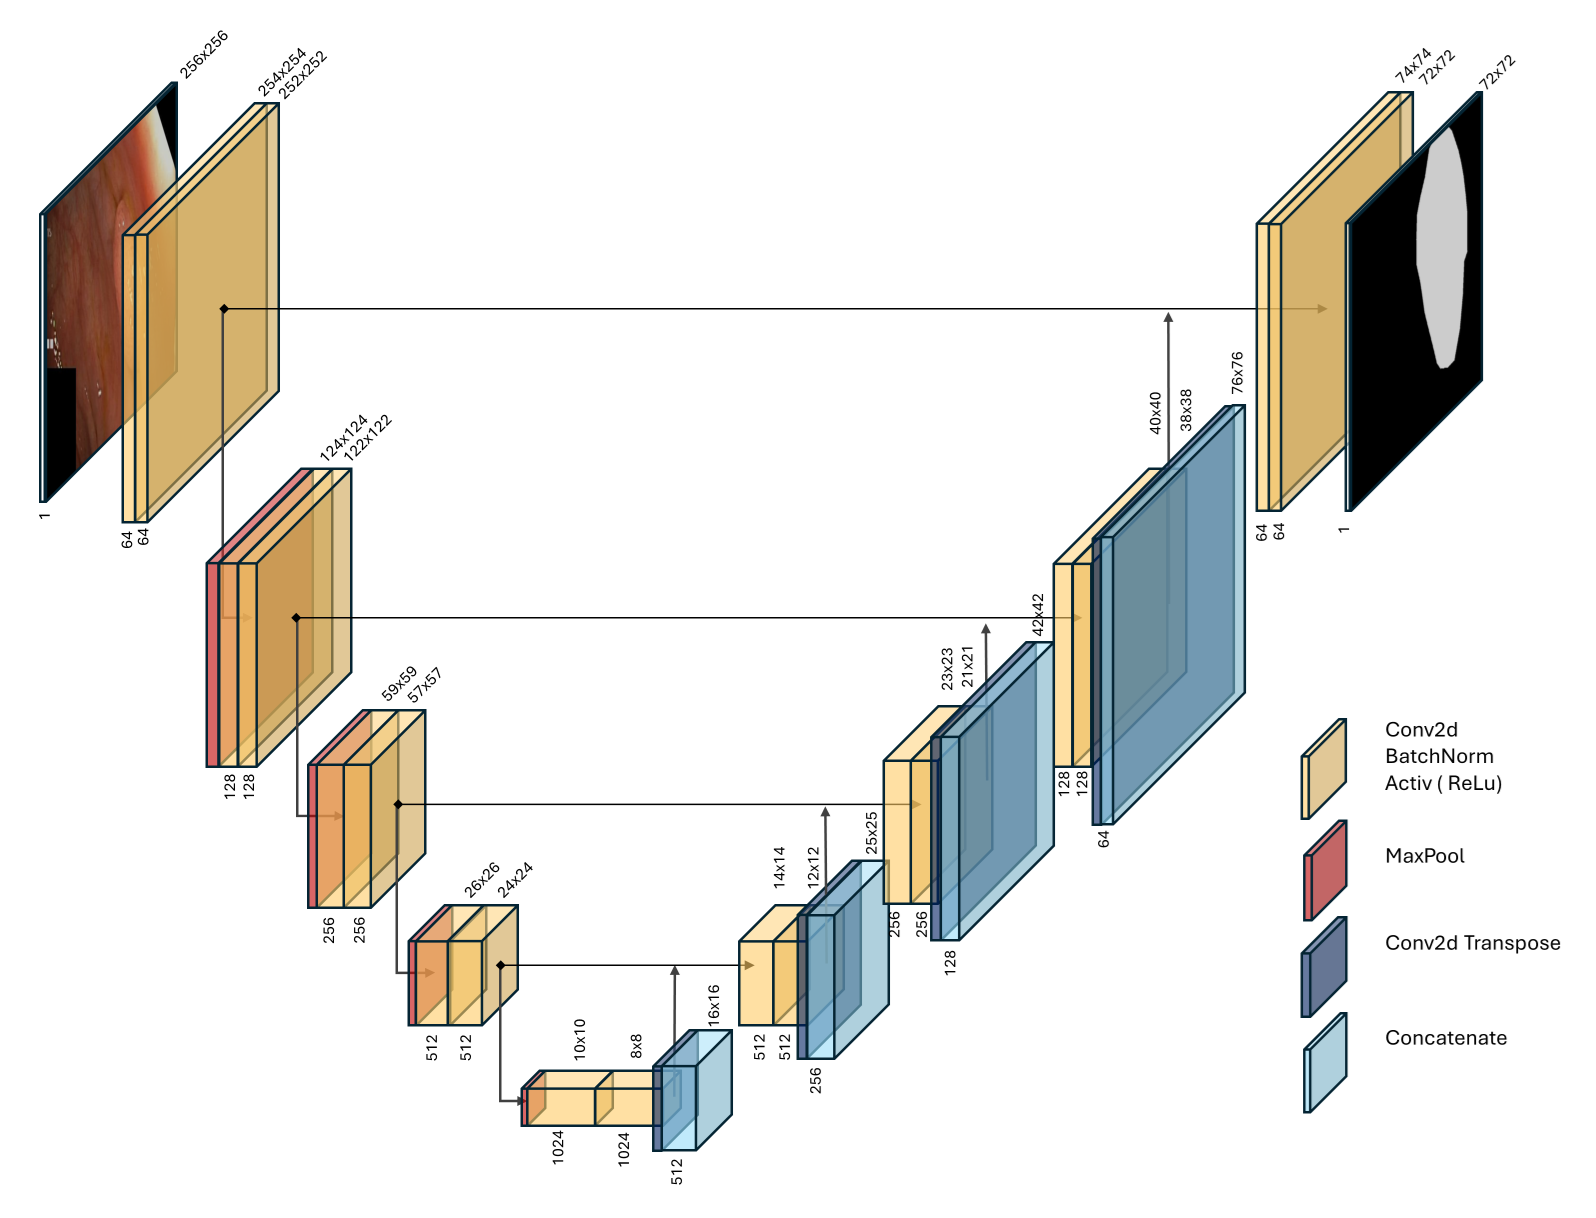

1. **Encoder (Downsampling Path):** The encoder captures the context in the image. It consists of a series of convolutional layers, batch normalization layers, activation functions (usually ReLU), and max-pooling layers. Each step down the U consists of two convolutions followed by a max-pooling operation to reduce the dimensions of the feature maps. This helps the network learn increasingly abstract features.

2. **Decoder (Upsampling Path):** The decoder enables precise localization using transposed convolutions. It consists of a series of up-convolutional layers (or transposed convolutions), concatenation with feature maps from the encoder (skip connections), followed by regular convolutions. The transposed convolutions increase the dimensions of the feature maps.

3. **Skip Connections:** These are the "bridges" between the encoder and decoder. They help the decoder recover the spatial information lost during encoding, which is crucial for achieving precise segmentation.

4. **Bottleneck:** This is the deepest layer in the U-Net, connecting the encoder and decoder. It usually consists of convolutions and activation functions but no pooling. This layer is responsible for the most abstract feature representations.

5. **Output Layer:** The final layer is a 1x1 convolution followed by an activation function like sigmoid (for binary segmentation) or softmax (for multi-class segmentation).

In this implementation, Batch Normalization layers were included to stabilize the training process. Additionally, experiments were conducted with the inclusion of Dropout layers, varying the L2 regularizer strength (from 1e-6 to 1e-3), and testing different initializers (He normal and the default Glorot uniform).

The optimal combination for achieving the best model performance for the task was determined to be excluding the Dropout layer, using the default initializer, and applying an L2 regularizer with a regularization factor of 1e-5.

In [ ]:
# Set seeds for reproducibility
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

<a name="model-configuration"></a>
### Model configuration

In this section, the U-Net model will be configured for training. Prior to this, parameters will be set to construct the U-Net model.

In [ ]:
# Get the shape of the input images
x = train_images_gen.__next__()
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Number of classes (binary segmentation)
n_classes = 1

# Learning rate
lr = 1e-4

Checking the batch size, input shape, and output shape.

In [ ]:
# batch size
x.shape[0]

16

In [ ]:
# input shape
input_shape

(256, 256, 3)

In [ ]:
# target shape
y = train_masks_gen.__next__()
y.shape[1:]

(256, 256, 1)

To successfully compile the model, the optimizer, loss function, and metrics need to be input correctly. The typical Accuracy metric, which calculates how often predictions match labels, will be used. Additionally, various combinations of optimizers (Adam and Nadam) and loss functions (Binary Crossentropy, Dice Loss and IoU Loss) will be tested.

In [ ]:
# Build and compile the U-Net model
model = build_unet(input_shape, n_classes=n_classes)

# Compile the model with different loss functions and optimizers
model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

Output activation: sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0        

After experimenting with different loss functions and optimizers, the best combination that gives us the best model performance for our task is the Adam optimzer with Binary Crossentropy loss function.

<a name="model-training"></a>
### Model training

Once the model is successfully compiled, it is ready for training. The following are key points for setting up the training process correctly:

1. **Epochs and Steps**: The number of epochs is set to 120, with steps per epoch calculated based on the training data.

2. **Model Checkpoint**: The best model is saved based on validation loss, allowing for training to resume or predictions to be made later.

3. **Early Stopping**: Early stopping with a patience of 10 epochs is implemented to prevent overfitting and reduce training time.

4. **Learning Rate Reduction**: The `ReduceLROnPlateau` callback is used to lower the learning rate if the validation loss plateaus, aiding in better model convergence.

5. **Training**: The `fit` method is used with training and validation data generators, adhering to the standard approach for training a Keras model.

6. **Callbacks**: Multiple callbacks (`model_checkpoint`, `early_stopping`, and `reduce_lr`) are included to monitor and adjust the training process.

In [ ]:
# Set parameters for training
epochs = 120
steps_per_epoch = train_images_gen.samples // train_images_gen.batch_size
validation_steps = validation_images_gen.samples // validation_images_gen.batch_size

# Set up callbacks for model checkpoints, early stopping, and learning rate reduction
checkpoint_path = './model/unet.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-5)

# Fit the model using the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

# Save the model architecture to a JSON file if needed
model_json = model.to_json()
with open("./model/unet_model.json", "w") as json_file:
    json_file.write(model_json)



Epoch 1/120
57/57 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.7431
Epoch 1: val_loss improved from inf to 0.68504, saving model to ./model/unet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 133s 1s/step - loss: 0.5628 - accuracy: 0.7431 - val_loss: 0.6850 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 2/120
57/57 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.8297
Epoch 2: val_loss improved from 0.68504 to 0.60384, saving model to ./model/unet.h5
57/57 [==============================] - 55s 970ms/step - loss: 0.4362 - accuracy: 0.8297 - val_loss: 0.6038 - val_accuracy: 0.8266 - lr: 1.0000e-04
Epoch 3/120
57/57 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8299
Epoch 3: val_loss improved from 0.60384 to 0.51247, saving model to ./model/unet.h5
57/57 [==============================] - 58s 1s/step - loss: 0.4158 - accuracy: 0.8299 - val_loss: 0.5125 - val_accuracy: 0.8296 - lr: 1.0000e-04
Epoch 4/120
57/57 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.8316
Epoch 4: val_loss did not improve from 0.51247
57/57 [==============================] - 54s 940ms/step - 

When the training is completed, the `fit` method will return a **History** object, which is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values.

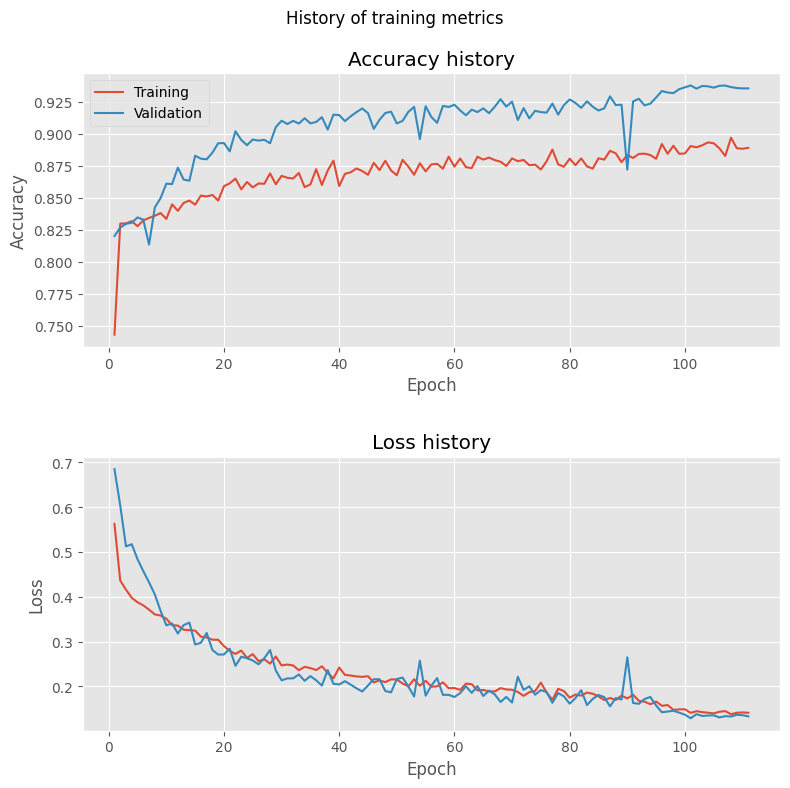

In [ ]:
# Get the history of accuracy and loss from the `history` object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create subplots for accuracy and loss
fig, axes = plt.subplots(2,1, figsize=(8, 8))

axes[0].plot(range(1, len(accuracy) + 1), accuracy, label='Training')
axes[0].plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy history')
axes[0].legend()

axes[1].plot(range(1, len(loss) + 1), loss, label='Training')
axes[1].plot(range(1, len(val_loss) + 1), val_loss, label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss history')

# Adjust the layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top = 0.9, hspace = 0.4)
fig.suptitle("History of training metrics")
plt.show()

Based on the training history, the following conclusions can be drawn:

- Validation Loss: The validation loss generally decreases, indicating that the model is learning to generalize well to unseen data. The lowest validation loss recorded is 0.12861 at Epoch 101.

- Training Accuracy: The training accuracy fluctuates between 88-90%, suggesting that the model performs reasonably well on the training data.

- Validation Accuracy: The validation accuracy is typically higher than the training accuracy, often exceeding 92%. This is a positive indicator that the model is not overfitting and generalizes well to new data.

Overall, the model shows strong performance, with robust validation metrics and no immediate signs of overfitting. However, in image segmentation, accuracy might not always be the most informative metric due to class imbalances. For instance, the object of interest (e.g., a polyp) might occupy a very small portion of the image. A model predicting every pixel as the majority class (background) could still achieve high accuracy but would perform poorly in predicting the minority class (object of interest).

Therefore, in the next section, other metrics more suitable for evaluating segmentation performance will be considered.



<a name="model-evaluation"></a>
### Model evaluation

Other than accuracy, the other metrics that are often used in evaluating segmentation performance are:
- Precision
- Recall
- IoU (Intersection over Union)
- Dice Coefficient


In [ ]:
# Load the saved model
saved_model_path = './model/unet.h5'
loaded_model = tf.keras.models.load_model(saved_model_path)

<a name="confusion-matrix"></a>
#### Confusion matrix

All presented metrics above are based on the computation of a **confusion matrix**, which represent the number of pixels that were correctly or incorrectly classified as either the object of interest or the background.

4/4 [==============================] - 27s 395ms/step
Confusion Matrix:
 [[5370989   48994]
 [ 286690  846927]]


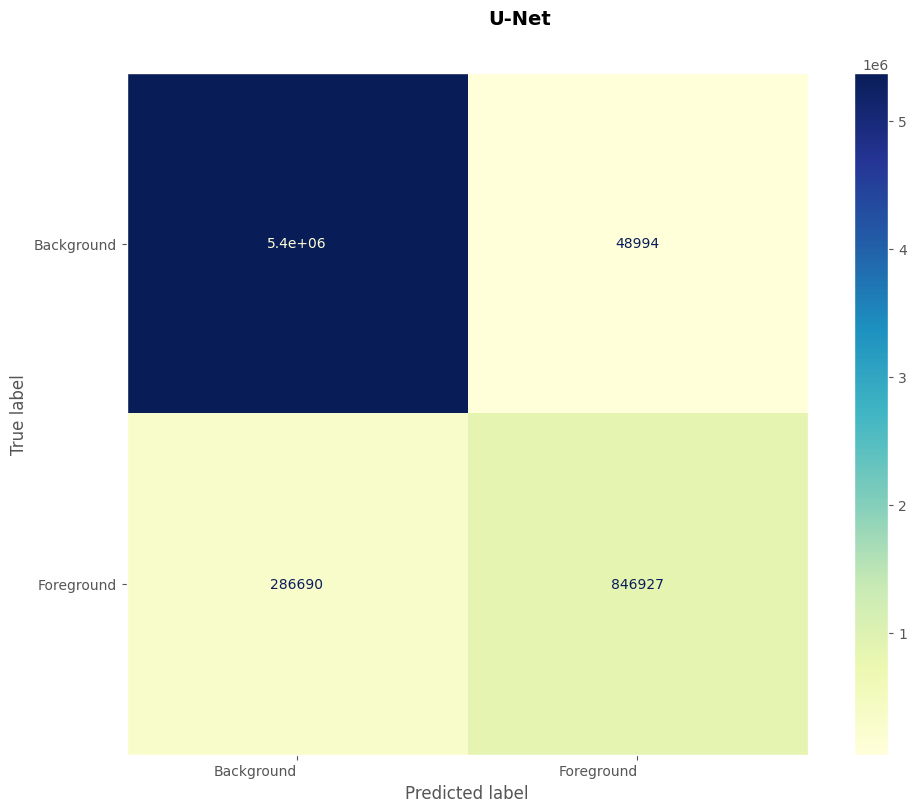

In [ ]:
test_image = test_images_gen[0]
test_mask = test_masks_gen[0]

# Generate predictions for the test image
prediction = loaded_model.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Convert masks to 1D arrays and flatten them
test_mask_flat = test_mask.ravel()
binary_prediction_flat = binary_prediction.ravel()

# Convert binary masks to binary labels (0 or 1)
test_masks_binary = (test_mask_flat > 0).astype(np.uint8)
segmentations_binary = (binary_prediction_flat > 0).astype(np.uint8)

# Flatten the binary masks
test_masks_flat = tf.reshape(test_masks_binary, [-1])
segmentations_flat = tf.reshape(segmentations_binary, [-1])

class_names = ["Background", "Foreground"]

# Confusion Matrix
conf_matrix = confusion_matrix(test_masks_flat, segmentations_flat)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix
fig, axes = plt.subplots(figsize=(10,8))
plt.tight_layout()
plt.subplots_adjust(top=0.9)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.YlGnBu, ax=axes)
disp.ax_.grid(False)

plt.setp(disp.ax_.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=10)
plt.setp(disp.ax_.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=10)
disp.figure_.suptitle("U-Net", fontsize=14, weight='bold')

plt.show()

From the confusion matrix, we can observe that:
- **True Positive (TP):** 846.927 pixels were correctly identified as the object of interest.
- **True Negative (TN):** 5'370.989 pixels were correctly identified as the background.
- **False Positive (FP):** 48.994 pixels were incorrectly identified as the object of interest.
- **False Negative (FN):** 286.690 pixels were incorrectly identified as the background.

<a name="precision-and-recall"></a>
#### Precision and Recall

It is posible to use the values from the confusion matrix (TP, TN, FP, and FN) to calculate evaluation metrics such as precision, recall, IoU, and dice coefficient, which provide a comprehensive assessment of the model's segmentation performance.

In [ ]:
class_names = ["Background", "Foreground"]

# Generate the classification report
report = classification_report(test_masks_binary, segmentations_binary, target_names=class_names)

print(report)

              precision    recall  f1-score   support

  Background       0.95      0.99      0.97   5419983
  Foreground       0.95      0.75      0.83   1133617

    accuracy                           0.95   6553600
   macro avg       0.95      0.87      0.90   6553600
weighted avg       0.95      0.95      0.95   6553600



The model is more conservative in predicting the foreground class, as indicated by the high precision but lower recall. This means that the model is missing some pixels that should be classified as foreground.

The model performs exceptionally well in classifying the background, as indicated by the high scores across all metrics.

In summary, the model performs fairly well but could benefit from techniques aimed at improving the recall for the foreground class.

<a name="iou-and-dice-coefficient-(f1-score)"></a>
#### IoU and Dice coefficient (F1 score)

F-measure, also called F-score, is one of the most widespread scores for performance measuring in MIS (Medical Image Segmentation). Based on the F-measure, there are two popular utilized metrics in MIS:
- Intersection over Union (IoU)
- Dice coefficient

**Intersection over Union (IoU)**, also known as *Jaccard index*, is the area of the intersection over union of the predicted segmentation and the ground truth.
$$
IoU = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}
$$
<br>

**Dice coefficient = F1-score**, is the harmonic mean of precision and recall. In another words, dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images
$$
Dice = \frac{2 \times \text{TP}}{2 \times \text{TP} + \text{FP} + \text{FN}}
$$
<br>


In [ ]:
# Initialize variables to store the total intersection, union, and sums for Dice coefficient
total_intersection = 0
total_union = 0
total_dice_numerator = 0
total_dice_denominator = 0

# Initialize lists to store IoU and Dice scores for each batch
iou_scores = []
dice_scores = []

# Get the total number of samples in the test set
num_samples = len(test_masks_gen)

# Define a function to calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_numerator = 2.0 * intersection
    dice_denominator = np.sum(y_true) + np.sum(y_pred)
    return dice_numerator, dice_denominator

# Compute Intersection over Union (IoU) and Dice coefficient for each batch in the test set
for i in range(num_samples):
    # Get the next batch of test images and masks
    batch_images = test_images_gen[i]
    batch_masks = test_masks_gen[i]

    # Generate predictions for the batch
    batch_predictions = loaded_model.predict(batch_images, verbose=0)

    # Threshold the predictions to obtain binary masks
    binary_predictions = (batch_predictions > 0.5).astype(np.uint8)

    # Compute intersection and union for the batch
    intersection = np.logical_and(batch_masks, binary_predictions)
    union = np.logical_or(batch_masks, binary_predictions)

    # Compute IoU for the batch
    batch_iou = np.sum(intersection) / np.sum(union)
    iou_scores.append(batch_iou)

    # Compute Dice coefficient for the batch
    dice_numerator, dice_denominator = dice_coefficient(batch_masks, binary_predictions)
    batch_dice = dice_numerator / dice_denominator
    dice_scores.append(batch_dice)

    # Update the totals
    total_intersection += np.sum(intersection)
    total_union += np.sum(union)
    total_dice_numerator += dice_numerator
    total_dice_denominator += dice_denominator

# Compute the mean IoU and Dice coefficient across all batches
mean_iou = total_intersection / total_union
mean_dice = total_dice_numerator / total_dice_denominator

# Compute the standard deviation for IoU and Dice coefficient
std_iou = np.std(iou_scores)
std_dice = np.std(dice_scores)

# Print the mean and standard deviation for IoU and Dice coefficient
print(f"Mean IoU: {mean_iou}")
print(f"Mean Dice Coefficient: {mean_dice}")
print(f"Std IoU: {std_iou}")
print(f"Std Dice Coefficient: {std_dice}")

Mean IoU: 0.7166798662277656
Mean Dice Coefficient: 0.8712474690261554
Std IoU: 0.0005950368895416003
Std Dice Coefficient: 7.41717840980205e-05


An IoU of 0.7167 is reasonably good, indicating that a significant portion of the ground truth overlaps with the predicted segmentation.

A Dice Coefficient of 0.8712 is also strong, suggesting a high degree of overlap between the predicted and ground truth segments. Dice Coefficients close to 1 are indicative of excellent model performance.

<a name="mask-prediction"></a>
### Mask prediction

Four evaluation metrics—precision, recall, IoU, and dice coefficient—have been investigated to assess the model's effectiveness in segmenting polyps. To gain a comprehensive view of the model's performance, a qualitative assessment through visual inspections can now be conducted.

4/4 [==============================] - 2s 552ms/step
Random indices: [6, 34, 11, 98, 52]


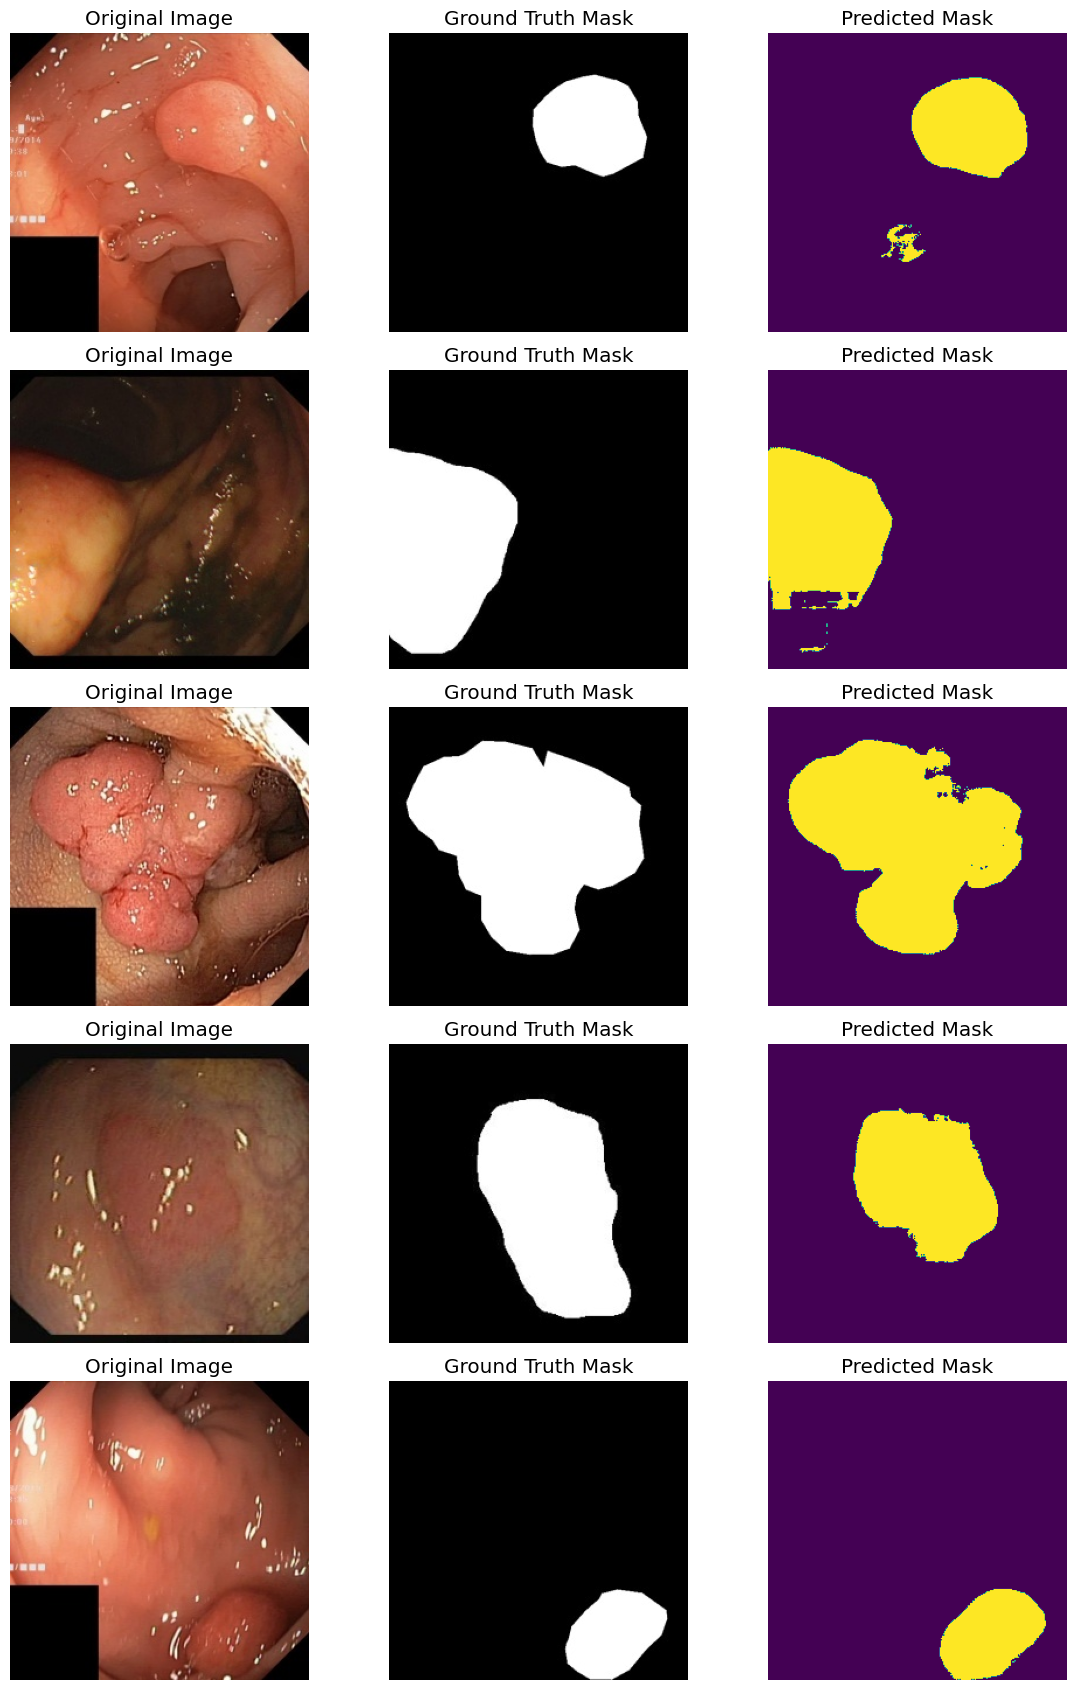

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Get the corresponding test image and mask (from only 1 batch)
test_image = test_images_gen[0]
test_mask = test_masks_gen[0]

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_image)), 5)

# Generate predictions for the test image
prediction = loaded_model.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_image[random_index])  # test_image is a batch, we extract the first image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_mask[random_index], cmap='gray')  # test_mask is a batch, we extract the first mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_prediction[random_index], cmap='viridis')  # binary_prediction is a batch, we extract the first prediction
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

The segmentation mask predicted by the model demonstrates a significant resemblance in morphology to the ground truth, effectively capturing the overall shape and contours of the target area. However, minor inconsistencies in boundary delineations suggest potential for further refinement in the model's spatial accuracy. Rather than relying solely on the conventional U-Net architecture, alternative models explicitly tailored to enhance boundary delineation in segmentation tasks, such as V-Net, DeepLab, Mask R-CNN, among others, could be explored.

Moreover, the presence of spurious detections or false positives in the predicted mask adversely affects the model's precision. These inaccuracies indicate an overly optimistic identification of polyps by the model. Addressing this issue involves adjusting the prediction threshold to mitigate false positives, although this adjustment may also decrease the model's sensitivity to true positives. In a medical context, striking a delicate balance between precision and sensitivity is crucial and ideally requires input from clinical experts.

<a name="conclusion"></a>
### Conclusion

The model's performance evaluation reveals notable strengths and areas for improvement:

- High Accuracy: With an impressive overall accuracy of 95%, the model demonstrates robust performance.

- Good Precision and Recall: Both precision and recall metrics surpass 75%, indicating the model's reliability in identifying and classifying target regions accurately.

- Effective Morphological Similarity: The model adeptly captures the general shape and contours of the target, showcasing promising performance in this aspect.

- Boundary Delineation: Spatial accuracy, particularly at the target's boundaries, requires refinement for more precise delineation.

- Addressing False Positives: The presence of spurious detections suggests room for improvement in precision to reduce false positives and enhance overall model performance.